In [1]:
import seaborn as sns
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
from sklearn.metrics import roc_curve,auc, precision_score,precision_recall_curve,recall_score,precision_recall_fscore_support,confusion_matrix
import numpy as np
from prettytable import PrettyTable
print(torch.cuda.is_available())
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
print(torch.cuda.get_device_properties(0).total_memory)
print(torch.cuda.memory_allocated())
gpu_id = 3

True
11721506816
0


In [2]:
class Model_class(object):

    def __init__(self,py_model,gpu_id=2):
        self.model = py_model
        self.fpr = {}
        self.tpr = {}
        self.auc_ = {}

        self.best_valid_acc = 0.65
        self.best_model = None
        self.best_optimizer = None

        self.val_acc = []
        self.train_acc = []
        self.val_loss = []
        self.train_loss = []

        self.gpu_id=gpu_id
        self.model = self.model.cuda(self.gpu_id)
        

    def train(self,train_loader,optimizer,Losses_,lr,n_epochs,validate_loader,schedular,regularization = 'None'):
        weight_decay = 0.0001
        self.n_epochs = n_epochs
        
        for epochs in range(n_epochs):
            batch_loss = []
            batch_acc = [] 
            val_batch_loss= []
            val_batch_acc = []
            for idx , (data,target) in enumerate(train_loader):


                """ mean normalization """
                data = self.Normalize_train(data)
                
                data = data.cuda(self.gpu_id)
                target = target.cuda(self.gpu_id)
                
                scores = self.model(data)
                
                reg_loss = 0
                if (regularization == 'l1'):
                    for params in self.model.parameters():
                        reg_loss += torch.sum(abs(params))

                if (regularization == 'l2'):
                    for params in self.model.parameters():
                        reg_loss += torch.norm(params)
                    
                loss = Losses_(scores,target) + weight_decay * reg_loss
                batch_loss.append(float(loss))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                batch_accuracy = self.evaluate_batch(data,target)
                batch_acc.append(float(batch_accuracy))
                #print(f'Train batches done: {idx+1}', end='\r')
                
            self.model.eval()

            for idx ,(data,target) in enumerate(validate_loader):

                data = self.Normalize(data)

                data = data.cuda(self.gpu_id)
                target = target.cuda(self.gpu_id)

                scores = self.model(data)
                loss = Losses_(scores,target)
                val_batch_loss.append(float(loss))

                batch_accuracy = self.evaluate_batch(data,target)
                val_batch_acc.append(float(batch_accuracy))
                #print(f'Validation batches done: {idx+1}', end='\r')

            self.model.train()

            occupied_memory = torch.cuda.memory_allocated(self.gpu_id)/(1024*1024*1024)
            total_memory = torch.cuda.get_device_properties(self.gpu_id).total_memory/(1024*1024*1024)

            self.train_loss.append(batch_loss)
            self.train_acc.append(batch_acc)
            self.val_loss.append(val_batch_loss)
            self.val_acc.append(val_batch_acc)

            valid_acc = np.mean(val_batch_acc)
            if(valid_acc > self.best_valid_acc):
                print("one of the best validation acc found")
                self.best_valid_acc = valid_acc
                self.best_model = copy.deepcopy(self.model.state_dict())  
                self.best_optimizer = copy.deepcopy(optimizer.state_dict())
            
            schedular.step()

            print(f'epoch:[{epochs+1}/{n_epochs}],memory:[{occupied_memory}/{total_memory}], lr:[{optimizer.param_groups[0]["lr"]}]') 
            print(f'train_accuracy:{np.mean(batch_acc)}, train_loss:{np.mean(batch_loss)}')
            print(f'val_acc:{np.mean(val_batch_acc)},val_loss:{np.mean(val_batch_loss)}')
            print()
                

    def Normalize_train(self,data):
        data = data/255
        for i in range(data.shape[0]):
            mean = torch.mean(data[i],dim = [1,2])
            std = torch.std(data[i],dim=[1,2])
            transform = transforms.Compose([transforms.RandomHorizontalFlip(p = 0.2),
    #                                         transforms.RandomRotation(10),
                                            transforms.Normalize(mean,std)])
            data[i] = transform(data[i])
        return data

    def Normalize(self,data):
        data = data/255
        for i in range(data.shape[0]):
            mean = torch.mean(data[i],dim = [1,2])
            std = torch.std(data[i],dim=[1,2])
            transform = transforms.Compose([transforms.Normalize(mean,std)])
            data[i] = transform(data[i])
        return data

    def evaluate(self,loader,name='test'):
        
        self.model.eval()
        correct = 0;samples =0

        pre = []
        lab = []
        predicted_labels = []

        with torch.no_grad():
            for idx,(x,y) in enumerate(loader):

                x = self.Normalize(x)
                x = x.cuda(self.gpu_id)
                y = y.cuda(self.gpu_id)

                scores = self.model(x)
                predict_prob = F.softmax(scores)
                _,predictions = predict_prob.max(1)

                predictions = predictions.to('cpu')
                y = y.to('cpu')
                predict_prob = predict_prob.to('cpu')

                predicted_labels.extend(list(predictions.numpy()))
                pre.extend(list(predict_prob.numpy()))
                lab.extend(list(y.numpy()))

                correct += (predictions == y).sum()
                samples += predictions.size(0)

                # torch.cuda.empty_cache(self.gpu_id)

            print(f'correct are {correct}/{samples}')

            lab = np.array(lab)
            pre = np.array(pre)

        self.fpr[name],self.tpr[name],_ = roc_curve(lab,pre[:,1])
        self.auc_[name] = auc(self.fpr[name],self.tpr[name])
        self.model.train()
        return lab,pre,predicted_labels,correct/samples 
        

    def evaluate_batch(self,batch,labels):
        
        self.model.eval()

        correct = 0;samples=0;

        with torch.no_grad():
            scores = self.model(batch)

            scores =F.softmax(scores,dim=1)
            _,predicted = torch.max(scores,dim = 1)
            correct += (predicted == labels).sum()
            samples += scores.shape[0]

            # torch.cuda.empty_cache(self.gpu_id)
            self.model.train()

        return correct/samples

    def print_params(self):
        # table = PrettyTable(["layer","parameters"])

        total_parameters = 0
        for name,parameter in self.model.named_parameters():
            if not parameter.requires_grad:
                continue
            param = parameter.numel()
            # table.add_row([name,param])
            total_parameters += param

        # print(table)
        print(f"total_trainable_parameters are : {total_parameters}")

    def plot_roc(self,color,name='test'): # name can be test train or validation
        plt.figure(figsize=(8,5))
        plt.plot(self.fpr[name],self.tpr[name],label=f"{name}:{self.auc_[name]}",color=color)
        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.legend()
        plt.title(f'{name} ROC')
        plt.show()
        

    def plot_precision_recall(self,lab,pre,predicted_labels,name='test'):

        print(confusion_matrix(lab,predicted_labels))
        print("precision : ",precision_score(lab,predicted_labels))
        print("recall : ",recall_score(lab,predicted_labels))
        precision_test,recall_test,_= precision_recall_curve(lab,pre[:,1])
        plt.plot(recall_test,precision_test,color='red')
        plt.xlabel("recall")
        plt.ylabel("precision")
        plt.title(f"precision_recall_curve for {name}")
        plt.show()

    def loss_curve(self):
        plt.plot(list(range(1,self.n_epochs+1)),np.mean(self.train_loss,axis=1),color='orange',label='train_loss')
        plt.plot(list(range(1,self.n_epochs+1)),np.mean(self.val_loss,axis=1),color='blue',label='validation_loss')
        plt.legend()
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.show()

    def accuracy_curve(self):
        plt.plot(list(range(1,self.n_epochs+1)),np.mean(self.train_acc,axis=1),color='orange',label='train_acc')
        plt.plot(list(range(1,self.n_epochs+1)),np.mean(self.val_acc,axis=1),color='blue',label='validation_acc')
        plt.xlabel("epochs")
        plt.ylabel("accuracy")
        plt.legend()
        plt.show()

    def save_model(self,directory,message):
        try:
            torch.save({'best_model':self.best_model,'best_optimizer':self.best_optimizer,'message':message},directory)
            print("model saved")
        except Exception as e:
            print(e)

In [3]:
path0 = '../../dataset/stanford_chest_train/1'
path1 = '../../dataset/stanford_chest_train/0'
print(len(os.listdir(path0)),len(os.listdir(path1)))

1000 1000


In [4]:
my_path = '../../dataset/stanford_chest_train/'
path_0 = my_path+'0/'
path_1 = my_path + '1/'
print(len(os.listdir(path_0)))
print(len(os.listdir(path_1)))


# torchvision.transforms.Normalize(mean=torch.rand(3),std = torch.rand(3))
transformations = torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),
                                                  torchvision.transforms.CenterCrop(224),
                                                  torchvision.transforms.ToTensor()])

images = torchvision.datasets.ImageFolder(root=my_path,transform=transformations)

data = torch.utils.data.DataLoader(images)

# train_data,validate_data,test_data,extra = torch.utils.data.dataset.random_split(images,[8000,1500,2100,9733+9726-11600])
# train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=64,shuffle=True)
# validate_loader = torch.utils.data.DataLoader(dataset = validate_data,batch_size=64,shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=64,shuffle=True)


print(images.class_to_idx)

1000
1000
{'0': 0, '1': 1}


In [5]:
squeezenet = torchvision.models.squeezenet1_0(pretrained=True) # data again divided by 255

squeezenet.features[3].expand1x1 = nn.Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),groups=16)
squeezenet.features[3].expand3x3 = nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=16)

squeezenet.features[4].expand1x1 = nn.Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),groups=16)
squeezenet.features[4].expand3x3 = nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=16)

squeezenet.features[5].expand1x1 = nn.Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1),groups=32)
squeezenet.features[5].expand3x3 = nn.Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=32)

squeezenet.features[7].expand1x1 = nn.Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1),groups=32)
squeezenet.features[7].expand3x3 = nn.Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=32)

squeezenet.features[8].expand1x1 = nn.Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1),groups=48)
squeezenet.features[8].expand3x3 = nn.Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=48)

squeezenet.features[9].expand1x1 = nn.Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1),groups=48)
squeezenet.features[9].expand3x3 = nn.Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=48)

squeezenet.features[10].expand1x1 = nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),groups=64)
squeezenet.features[10].expand3x3 = nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=64)

squeezenet.features[12].expand1x1 = nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),groups=64)
squeezenet.features[12].expand3x3 = nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=64)

squeezenet.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
print(squeezenet)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), groups=16)
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), groups=16)
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
      (expand3x3_activation):

In [6]:
check = torch.load('../saved_models/merged_nih3.pth')
print(check['message'])
squeezenet.load_state_dict(check['model'])
#squeezenet.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))

{'pretrained': True, 'classifier_1': 'conv2d(512,2,ker=1,stri=1,pad=0)', 'cuda': 3, 'train': tensor(0.7036), 'test': tensor(0.6781), 'valid': tensor(0.6700)}


<All keys matched successfully>

In [7]:
model = Model_class(squeezenet,gpu_id)
model.print_params()

total_trainable_parameters are : 134850


In [8]:
lab_train,pre_train,predict_train,acc_train = model.evaluate(data,name='Denqueeze')
print('Accuracy:',acc_train)

correct are 1405/2000
Accuracy: tensor(0.7025)


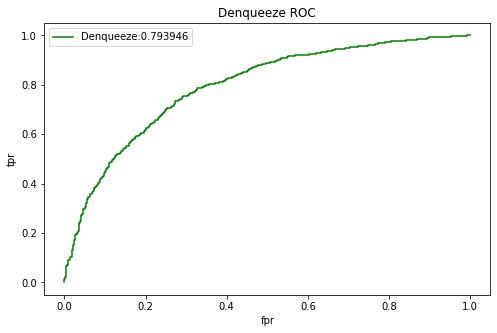

In [9]:
model.plot_roc('green',name='Denqueeze')

# Mobilenet v2 pretrained

In [10]:
mobilenet = torchvision.models.mobilenet_v2(pretrained=True)
mobilenet.classifier[1] = nn.Linear(1280,2,bias = True)
check = torch.load('../final/mobilenet_v2_pretrained.pth')
mobilenet.load_state_dict(check['model'])


model = Model_class(mobilenet,6)
lab_train,pre_train,predict_train,acc_train = model.evaluate(data,name='Mobilenet V2')
print('Accuracy:',acc_train)

correct are 1157/2000
Accuracy: tensor(0.5785)


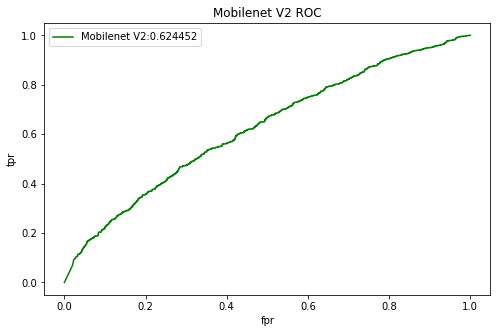

In [11]:
model.plot_roc('green',name='Mobilenet V2')

# Resnet 50 pretrained

In [12]:
resnet = torchvision.models.wide_resnet50_2(pretrained=True)
resnet.fc = nn.Linear(in_features = 2048, out_features = 2, bias = True)

check = torch.load('../final/resnet_pretrained.pth')
resnet.load_state_dict(check['model'])


model = Model_class(resnet,gpu_id)
lab_train,pre_train,predict_train,acc_train = model.evaluate(data,name='Resnet')
print('Accuracy:',acc_train)

correct are 1326/2000
Accuracy: tensor(0.6630)


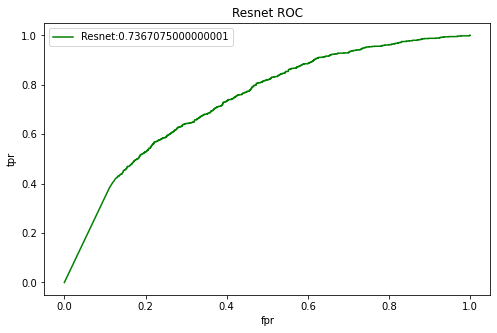

In [13]:
model.plot_roc('green',name='Resnet')

# Mobilenet V3

In [14]:
mobilenet = torchvision.models.mobilenet_v3_small(pretrained=True)
mobilenet.classifier[3] = nn.Linear(1024,2,bias = True)
check = torch.load('../final/mobilenet_v3_pretrained.pth')
mobilenet.load_state_dict(check['model'])


model = Model_class(mobilenet,gpu_id)
lab_train,pre_train,predict_train,acc_train = model.evaluate(data,name='Mobilenet V3')
print('Accuracy:',acc_train)

correct are 1192/2000
Accuracy: tensor(0.5960)


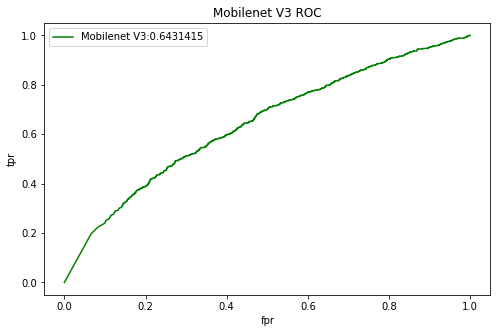

In [15]:
model.plot_roc('green',name='Mobilenet V3')

# Resnet without pretraining

In [16]:
resnet = torchvision.models.wide_resnet50_2(pretrained=False)
resnet.fc = nn.Linear(in_features = 2048, out_features = 2, bias = True)

check = torch.load('../final/resnet_untrained.pth')
resnet.load_state_dict(check['model'])


model = Model_class(resnet,gpu_id)
lab_train,pre_train,predict_train,acc_train = model.evaluate(data,name='Resnet')
print('Accuracy:',acc_train)

correct are 1237/2000
Accuracy: tensor(0.6185)


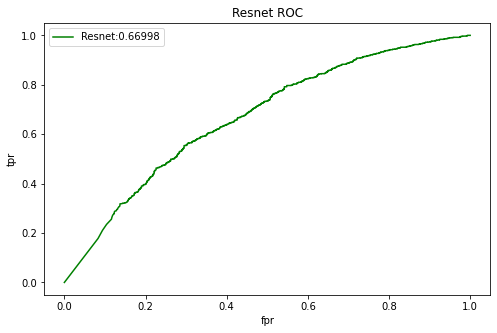

In [17]:
model.plot_roc('green',name='Resnet')

# Mobilenet v2 without pretraining

In [18]:
mobilenet = torchvision.models.mobilenet_v2(pretrained=True)
mobilenet.classifier[1] = nn.Linear(1280,2,bias = True)
check = torch.load('../final/mobilenet_v2_notpretrained.pth')
mobilenet.load_state_dict(check['model'])


model = Model_class(mobilenet,6)
lab_train,pre_train,predict_train,acc_train = model.evaluate(data,name='Mobilenet V2')
print('Accuracy:',acc_train)

correct are 1215/2000
Accuracy: tensor(0.6075)


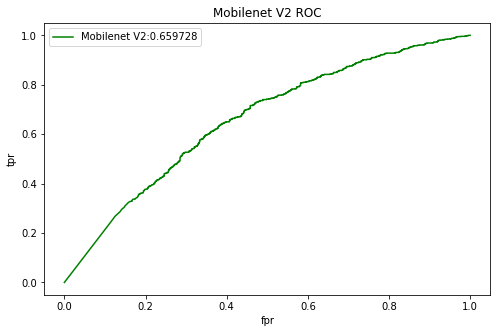

In [19]:
model.plot_roc('green',name='Mobilenet V2')

# Mobilenet V3 without pretraining

In [20]:
mobilenet = torchvision.models.mobilenet_v3_small(pretrained=False)
mobilenet.classifier[3] = nn.Linear(1024,2,bias = True)
check = torch.load('../final/mobilenet_v3_untrained.pth')
mobilenet.load_state_dict(check['model'])


model = Model_class(mobilenet,6)
lab_train,pre_train,predict_train,acc_train = model.evaluate(data,name='Mobilenet V3')
print('Accuracy:',acc_train)


correct are 1232/2000
Accuracy: tensor(0.6160)


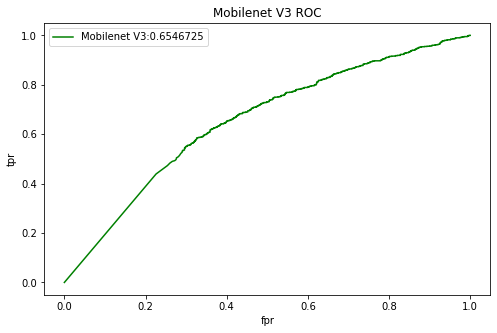

In [21]:
model.plot_roc('green',name='Mobilenet V3')